In [130]:
import gradio as gr
import pickle
import joblib
import numpy as np
from pyexpat import model
import json
import base64
import cv2
import pywt
from PIL import Image

In [198]:
class_dict = {'Cristiano Ronaldo': 0,
 'Dani Alves': 1,
 'Karim Benzema': 2,
 'Kevin De Bruyne': 3,
 'Lionel Messi': 4,
 'Luis Suarez': 5,
 'Luka Modric': 6,
 'Neymar Junior': 7,
 'Robert Lewandowski': 8,
 'Sergio Ramos': 9}

In [205]:
def load_saved_artifacts():
    #print("loading saved artifacts.....start")
    global __class_name_to_number
    global __class_number_to_name

    with open("C:\\Coding\\ML Practice\\Sports Celebrity\\server\\artifacts\\class_dictionary.json", "r") as f:
        __class_name_to_number = json.load(f)
        __class_number_to_name = {v:k for k,v in class_dict.items()}

    global __model
    if __model is None:
        with open('C:\\Coding\\ML Practice\\Sports Celebrity\\server\\artifacts\\saved_model.pkl', 'rb') as f:
            __model = joblib.load(f)

    #print("loading saved artifacts....done")   

Our Prediction: Cristiano Ronaldo
Our Prediction: Lionel Messi


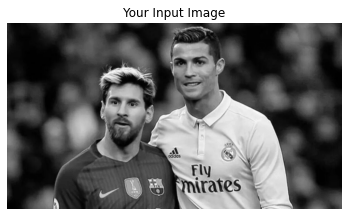

In [229]:
def w2d(img, mode='haar', level = 1):
    img = np.array(img, dtype=np.uint8)
    imArray = img
    # Datatype conversion
    # convert to grayscale
    imArray = cv2.cvtColor(imArray, cv2.COLOR_BGR2GRAY)
    # convert to float
    # compute coefficients
    coeffs = pywt.wavedec2(imArray, mode, level=level)
    
    coeffs_H = list(coeffs)
    coeffs_H[0] *= 0
    
    #reconstruction
    imArray_H = pywt.waverec2(coeffs_H, mode)
    imArray_H *= 255
    imArray_H = np.uint8(imArray_H)
    
    return imArray_H

__class_name_to_number = {}
__class_number_to_name = {}
__model = None 

def classify_image(img):
    imga = img
    imgs = get_cropped_image(img)
    result = []
    for img in imgs:
        scaled_raw_image = cv2.resize(img,(32,32))
        img_har = w2d(img,'db1',5)
        scaled_har_image = cv2.resize(img_har,(32,32))
        
        combined_img = np.vstack((scaled_raw_image.reshape(32*32*3,1),scaled_har_image.reshape(32*32*1,1)))
        len_image_array = 32*32*4

        final = combined_img.reshape(1,len_image_array).astype(float)
        class_dict = {}
        for i, name in zip(np.round(__model.predict_proba(final),2).tolist()[0],__class_name_to_number):
            class_dict[name] = i
        result.append((f'Our Prediction: {class_number_to_name(__model.predict(final)[0])}'))
    for i in result:
        print(i)

def class_number_to_name(class_num):
    return __class_number_to_name[class_num]

def get_cropped_image(img):
    face_cascade = cv2.CascadeClassifier('C:\\Coding\\ML Practice\\Sports Celebrity\\server\\opencv\\haarcascades\\haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier('C:\\Coding\\ML Practice\\Sports Celebrity\\server\\opencv\\haarcascades\\haarcascade_eye.xml')

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    cropped_faces = []
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            cropped_faces.append(roi_color)

    return cropped_faces                
  
if __name__ == '__main__':
    load_saved_artifacts()
    img = (cv2.imread('C:\\Coding\\ML Practice\\Sports Celebrity\\server\\test_images\\messi3.jpg'))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    plt.axis('off')
    plt.title('Your Input Image')
    plt.imshow(gray, cmap='gray')
    (classify_image(img))


In [167]:
# gr.Interface(fn=classify_image,
#              inputs = gr.inputs.Image(),
#              outputs = gr.outputs.Label(num_top_classes=3)).launch()